In [1]:
%matplotlib inline
import sys
sys.path.append('GAN')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
import numpy as np

import scipy
import moviepy.editor as mpy

In [2]:
from tensorflow.keras.datasets import mnist
# load data
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
# utility function
import scipy
import moviepy.editor as mpy
def visualize_imgs(imgs, shape, save_path=None):
    (row, col) = shape[0], shape[1]
    height, width = imgs[0].shape[:2]
    total_img = np.zeros((height*row, width*col))
    for n, img in enumerate(imgs):
        j = int(n/col)
        i = n%col
        total_img[j*height:(j+1)*height,i*width:(i+1)*width] = img
    if save_path is not None:
        scipy.misc.imsave(save_path, img)
    return total_img
  
def make_gif(images, fname, duration=2, true_image=False):    
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x+1)/2*255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
def iter_data(*data, **kwargs):
    size = kwargs.get('batch_size', 128)
    try:
        n = len(data[0])
    except:
        n = data[0].shape[0]
    batches = int(n / size)
    if n % size != 0:
        batches += 1
    for b in range(batches):
        start = b * size
        end = (b + 1) * size
        if end > n:
            end = n
        if len(data) == 1:
            yield data[0][start:end]
        else:
            yield tuple([d[start:end] for d in data])

In [4]:
class DCGAN(object):
    def __init__(self, image_size, image_channel, z_dim=128, learning_rate=1e-4):
        self.image_size = image_size
        self.image_channel = image_channel
        self.z_dim = z_dim
        self.learning_rate = learning_rate
        self.build_model()
    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size,
                                              self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)

        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_real,
                                          labels=tf.ones_like(self.logit_real)))
        self.d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake,
                                          labels=tf.zeros_like(self.logit_fake)))
        self.d_loss = self.d_loss_real + self.d_loss_fake

        # loss of generator
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake,
                                          labels=tf.ones_like(self.logit_fake)))
       
        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.d_loss,
                                                                            var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.g_loss,
                                                                             var_list=self.g_vars)

    def discriminator(self, image):
        lrelu = tf.nn.leaky_relu
        conv2d = tf.layers.conv2d
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense    
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
            if self.image_channel==1:
                image = tf.reshape(image, [-1, self.image_size, self.image_size, 1])
            hidden = self.z
            hidden = image
            hidden = lrelu(conv2d(hidden, 32, kernel_size=5, strides=2, padding='same'))
            hidden = lrelu(bn(conv2d(hidden, 128, kernel_size=5, strides=2, padding='same'),
                              training=True))
            hidden = tf.layers.flatten(hidden)
            hidden = lrelu(bn(linear(hidden, 1024), training=True))
            hidden = linear(hidden, 1)
            return tf.nn.sigmoid(hidden), hidden

    def generator(self, y=None):
        relu = tf.nn.relu
        deconv2d = tf.layers.conv2d_transpose
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope("generator"):
            self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
            hidden = self.z
            hidden = relu(bn(linear(hidden, 1024), training=True))
            hidden = relu(bn(linear(hidden, (self.image_size//4)*(self.image_size//4)*128),
                             training=True))
            hidden = tf.reshape(hidden, [-1, self.image_size//4, self.image_size//4, 128])
            hidden = relu(bn(deconv2d(hidden, 32, kernel_size=5, strides=2, padding='same'),
                             training=True))
            hidden = tf.nn.sigmoid(deconv2d(hidden, self.image_channel, kernel_size=5,
                                            strides=2, padding='same'))
            if self.image_channel==1:
                hidden = tf.reshape(hidden, [-1, self.image_size, self.image_size])
            return hidden
          
    def train(self, sess, x_train, num_epoch=100, batch_size=100, num_sample=100,
              show_samples=True, sample_path='./samples', n_critic=2, log=False):
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                batch_z = np.random.uniform(-1, 1,
                                            [batch_size, self.z_dim]).astype(np.float32)
                if counter % (n_critic+1) != 0:
                    # Update D network
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op],
                                         feed_dict=feed_dict)
                    d_losses.append(d_loss)
                else:
                    # Update G network
                    g_loss, _ = sess.run([self.g_loss, self.g_update_op],
                                         feed_dict={self.z: batch_z})
                    g_losses.append(g_loss)
                counter += 1
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20),
                                 save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
                
            if (epoch+1) % 10 == 0:
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch
      
    def save_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=step)
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))
        
    def load_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        saver = tf.train.Saver()
        if step is not None:
            saver.restore(sess, os.path.join(checkpoint_dir, model_name+'-{}'.format(step)))
        else:
            saver.restore(sess, os.path.join(checkpoint_dir, model_name))

In [5]:
#Inherit from DCGAN class
class WGAN(DCGAN):
    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size,
                                              self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)
        
        # change         
        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(self.logit_real)
        self.d_loss_fake = tf.reduce_mean(self.logit_fake)                        
        self.d_loss = self.d_loss_real - self.d_loss_fake
        
        # loss of generator
        self.g_loss = tf.reduce_mean(self.logit_fake)
       
         # gradient penalty
        epsilon = tf.random_uniform([], 0.0, 1.0)
        x_hat = self.image_real*epsilon + (1-epsilon)*self.image_fake
        _ , d_hat = self.discriminator(x_hat)
        gradients = tf.gradients(d_hat, x_hat)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1.0)**2)
        self.d_loss += gradient_penalty

        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.5, beta2=0.9)\
                .minimize(self.d_loss, var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.5, beta2=0.9)\
                .minimize(self.g_loss, var_list=self.g_vars)
            
    def train(self, sess, x_train, num_epoch=100, batch_size=100, 
              num_sample=100, show_samples=True, n_critic=2, 
              sample_path='./samples', log=True): 
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()        
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                for _ in range(5):
                    batch_z = np.random.uniform(-1, 1,[batch_size, self.z_dim]).astype(np.float32)
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op],
                                         feed_dict=feed_dict)
                    d_losses.append(d_loss)
                batch_z = np.random.uniform(-1, 1,[batch_size, self.z_dim]).astype(np.float32)
                g_loss, _ = sess.run([self.g_loss, self.g_update_op],
                                         feed_dict={self.z: batch_z})
                g_losses.append(g_loss)
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20),
                                 save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
#             if (epoch+1) % 10 == 0:
            self.save_model(sess, step=counter)
            if show_samples:
                plt.imshow(img, cmap = 'gray')
                plt.axis('off')
                plt.title('epoch {}'.format(epoch+1))
                plt.show()
            counter+=1
        return sample_imgs, d_loss_epoch, g_loss_epoch

In [6]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
wgan = WGAN(image_size=28, image_channel=1, learning_rate=5e-5)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

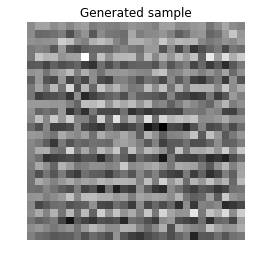

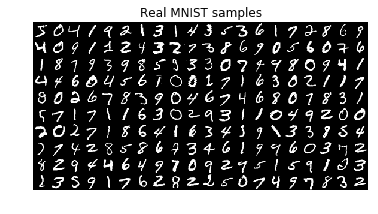

In [7]:
sample_z = np.random.uniform(-1, 1, size=(200 , wgan.z_dim))
samples = sess.run(wgan.image_fake, feed_dict = {wgan.z: sample_z})

plt.imshow(samples[0].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = x_train[:200]
img = visualize_imgs(samples, shape=(10,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

Epoch: [0] time: 48.95, d_loss: -7.7574, g_loss: -7.5091


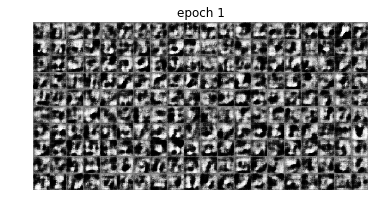

Epoch: [1] time: 97.93, d_loss: -15.1863, g_loss: -41.5425


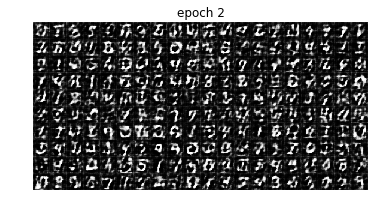

Epoch: [2] time: 146.65, d_loss: -11.1308, g_loss: -98.0267


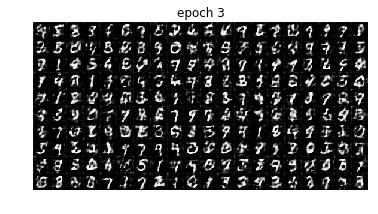

Epoch: [3] time: 196.23, d_loss: -15.8621, g_loss: -143.9553


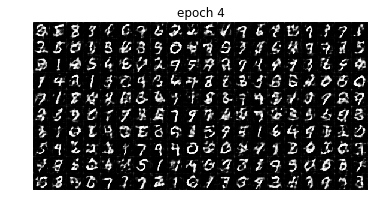

Epoch: [4] time: 249.03, d_loss: -19.8686, g_loss: -192.5198


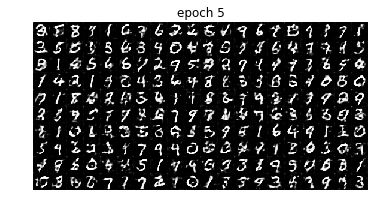

Epoch: [5] time: 301.94, d_loss: -13.6237, g_loss: -213.9105


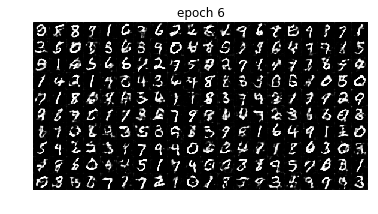

Epoch: [6] time: 354.96, d_loss: -7.0336, g_loss: -203.6418


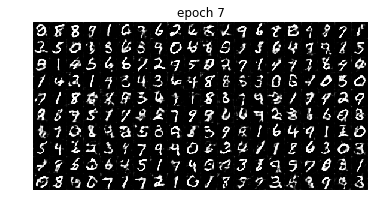

Epoch: [7] time: 407.53, d_loss: -3.5789, g_loss: -180.3765


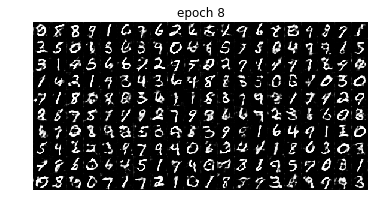

Epoch: [8] time: 460.48, d_loss: -1.2389, g_loss: -149.4978


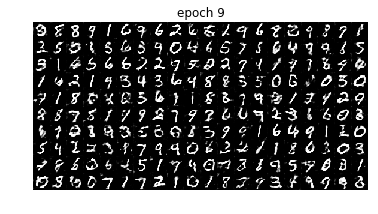

Epoch: [9] time: 513.47, d_loss: 2.8736, g_loss: -113.9853


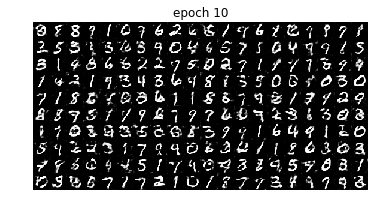

Epoch: [10] time: 566.17, d_loss: -3.6945, g_loss: -87.5127


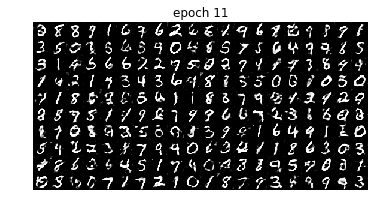

Epoch: [11] time: 619.19, d_loss: -5.7735, g_loss: -89.5289


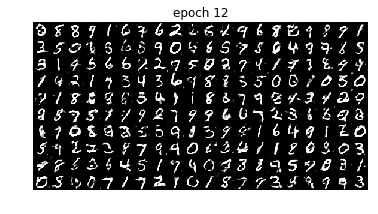

Epoch: [12] time: 672.04, d_loss: -6.2155, g_loss: -96.7812


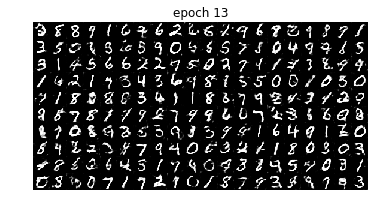

Epoch: [13] time: 724.88, d_loss: -5.9140, g_loss: -103.8985


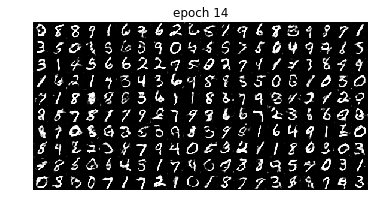

Epoch: [14] time: 777.78, d_loss: -5.8509, g_loss: -105.4472


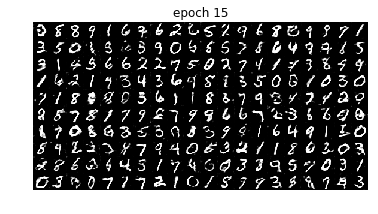

Epoch: [15] time: 830.78, d_loss: -5.5376, g_loss: -105.0528


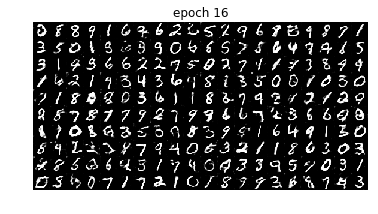

Epoch: [16] time: 883.76, d_loss: -5.4959, g_loss: -103.0266


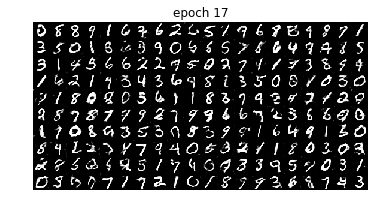

Epoch: [17] time: 936.88, d_loss: -5.0860, g_loss: -100.9259


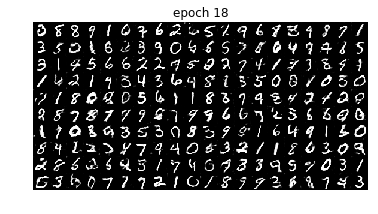

Epoch: [18] time: 990.08, d_loss: -4.5924, g_loss: -96.2562


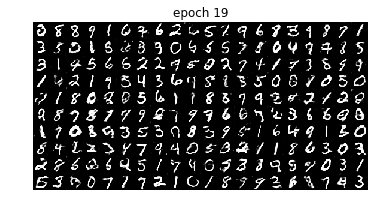

Epoch: [19] time: 1043.13, d_loss: -3.9965, g_loss: -88.9949


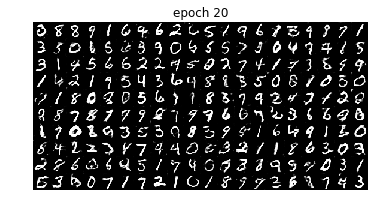

Epoch: [20] time: 1094.21, d_loss: -3.5140, g_loss: -81.3093


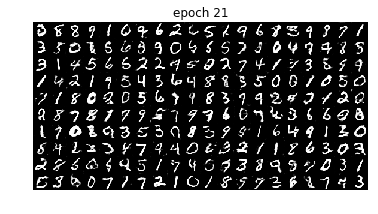

Epoch: [21] time: 1144.54, d_loss: -2.9551, g_loss: -75.4965


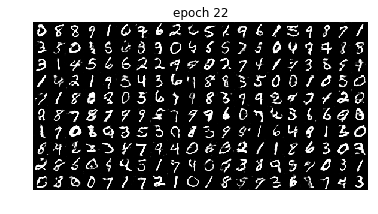

Epoch: [22] time: 1194.99, d_loss: -3.2247, g_loss: -74.9000


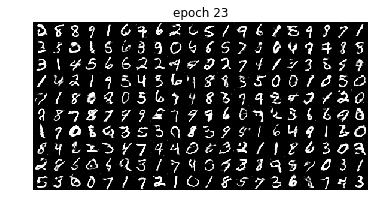

Epoch: [23] time: 1245.51, d_loss: -3.8307, g_loss: -80.7350


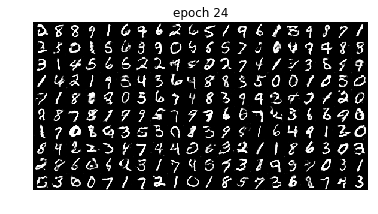

Epoch: [24] time: 1296.05, d_loss: -3.9027, g_loss: -87.6652


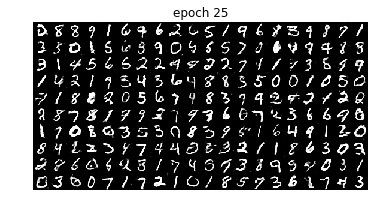

Epoch: [25] time: 1346.41, d_loss: -3.9455, g_loss: -92.4091


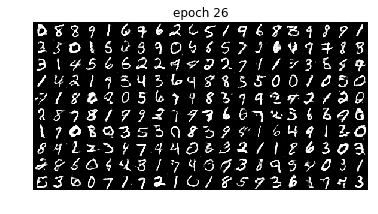

Epoch: [26] time: 1396.86, d_loss: -3.7999, g_loss: -93.6004


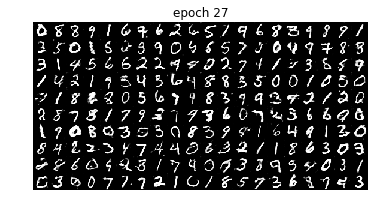

Epoch: [27] time: 1447.97, d_loss: -3.4020, g_loss: -92.4152


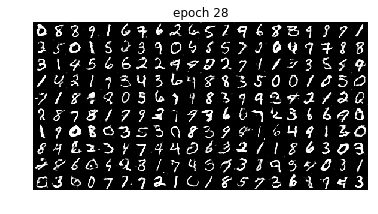

Epoch: [28] time: 1498.19, d_loss: -3.0933, g_loss: -87.7726


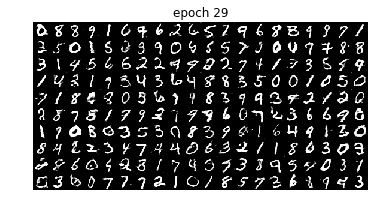

Epoch: [29] time: 1549.11, d_loss: -2.7146, g_loss: -80.1439


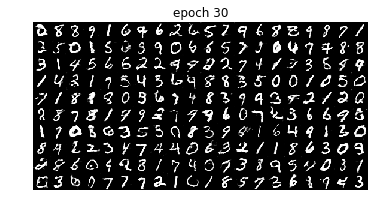

In [8]:
# Start training
sample_imgs, d_loss_epoch, g_loss_epoch = wgan.train(sess, x_train, num_sample=200, num_epoch=30, n_critic=5)

In [9]:
imgs = np.array(sample_imgs)
make_gif(imgs*255., 'gan1.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='gan1.gif')


[MoviePy] Building file dcgan1.gif with imageio


 97%|█████████▋| 30/31 [00:00<00:00, 69.95it/s]


### Report 

https://www.ctolib.com/tjwei-GANotebooks.html

https://hk.saowen.com/a/09b7ce57ed2ac910c9248b4769d67bd81aa5b256ed1b38411acee9da81c63bbe

使用gan的最明顯的好處是可以省下動畫製作成本，藉由gan和雜訊做一些細部的微調就可以做出全新的動畫人物，類似上一次lab變臉的技術。使用Improved WGAN 的好處是使用了權重剪枝的方法可以比WGAN更快的收斂速度，並生成更好的樣本。
